In [673]:
#importing necessary libraries
import pandas as pd
import glob
import os
import warnings
import time
import numpy as np
import sys
import matplotlib.pyplot as plt
import seaborn as sns
# importing custom scripts for different functions
sys.path.append('scripts')  # add scripts to path




# Ignore warnings
warnings.filterwarnings("ignore")

In [674]:
data = pd.read_csv("combined.csv")
data.head()

,Commodity,Classification,Grade,Sex,Market,Wholesale,Retail,Supply Volume,County,Date
0,Banana (Ripening),-,-,-,Mukuyu Market,-,50.00/Kg,NaN,Muranga,2026-02-11
1,Banana (Ripening),-,-,-,Mulot,70.00/Kg,100.00/Kg,1500.0,Bomet,2026-02-11
2,Banana (Ripening),-,-,-,Kitale Municipality Market,80.00/Kg,100.00/Kg,6000.0,Trans-Nzoia,2026-02-11
3,Banana (Ripening),-,-,-,Kerugoya,20.00/Kg,40.00/Kg,300.0,Kirinyaga,2026-02-10
4,Banana (Ripening),-,-,-,Bondeni,80.00/Kg,100.00/Kg,5000.0,Trans-Nzoia,2026-02-10


In [675]:
data.isnull().sum()

Commodity             0
Classification        0
Grade                 0
Sex                   0
Market                0
Wholesale             0
Retail                0
Supply Volume     17775
County               19
Date                  0
dtype: int64

In [676]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57010 entries, 0 to 57009
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Commodity       57010 non-null  object 
 1   Classification  57010 non-null  object 
 2   Grade           57010 non-null  object 
 3   Sex             57010 non-null  object 
 4   Market          57010 non-null  object 
 5   Wholesale       57010 non-null  object 
 6   Retail          57010 non-null  object 
 7   Supply Volume   39235 non-null  float64
 8   County          56991 non-null  object 
 9   Date            57010 non-null  object 
dtypes: float64(1), object(9)
memory usage: 4.3+ MB


In [677]:
data.duplicated().sum()

4259

In [678]:
data.drop_duplicates(inplace=True)
data.reset_index(drop=True, inplace=True)

In [679]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52751 entries, 0 to 52750
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Commodity       52751 non-null  object 
 1   Classification  52751 non-null  object 
 2   Grade           52751 non-null  object 
 3   Sex             52751 non-null  object 
 4   Market          52751 non-null  object 
 5   Wholesale       52751 non-null  object 
 6   Retail          52751 non-null  object 
 7   Supply Volume   36539 non-null  float64
 8   County          52743 non-null  object 
 9   Date            52751 non-null  object 
dtypes: float64(1), object(9)
memory usage: 4.0+ MB


In [680]:
data['County'] = data.groupby('Market')['County'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else "Unknown"))

In [681]:
# Filling NaNs using the median volume for each specific commodity
data['Supply Volume'] = data.groupby(['Commodity', 'Market'])['Supply Volume'].transform(lambda x: x.fillna(x.median()))
#data['Supply Volume'] = data['Supply Volume'].fillna(0)

In [682]:
data.isnull().sum()

Commodity            0
Classification       0
Grade                0
Sex                  0
Market               0
Wholesale            0
Retail               0
Supply Volume     9251
County               0
Date                 0
dtype: int64

In [683]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52751 entries, 0 to 52750
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Commodity       52751 non-null  object 
 1   Classification  52751 non-null  object 
 2   Grade           52751 non-null  object 
 3   Sex             52751 non-null  object 
 4   Market          52751 non-null  object 
 5   Wholesale       52751 non-null  object 
 6   Retail          52751 non-null  object 
 7   Supply Volume   43500 non-null  float64
 8   County          52751 non-null  object 
 9   Date            52751 non-null  object 
dtypes: float64(1), object(9)
memory usage: 4.0+ MB


In [684]:
data['Supply Volume'] = data.groupby('Commodity')['Supply Volume'].transform(lambda x: x.fillna(x.median()))

In [685]:
data= data.drop(columns=["Classification", "Grade", "Sex"])

In [686]:
data.head()

,Commodity,Market,Wholesale,Retail,Supply Volume,County,Date
0,Banana (Ripening),Mukuyu Market,-,50.00/Kg,1500.0,Muranga,2026-02-11
1,Banana (Ripening),Mulot,70.00/Kg,100.00/Kg,1500.0,Bomet,2026-02-11
2,Banana (Ripening),Kitale Municipality Market,80.00/Kg,100.00/Kg,6000.0,Trans-Nzoia,2026-02-11
3,Banana (Ripening),Kerugoya,20.00/Kg,40.00/Kg,300.0,Kirinyaga,2026-02-10
4,Banana (Ripening),Bondeni,80.00/Kg,100.00/Kg,5000.0,Trans-Nzoia,2026-02-10


In [687]:
data.isnull().sum()

Commodity        0
Market           0
Wholesale        0
Retail           0
Supply Volume    0
County           0
Date             0
dtype: int64

In [688]:
def clean_price(series):
	clean_series = pd.to_numeric(series.astype(str).str.replace('[^0-9.]', '', regex=True), errors='coerce')
	return clean_series

data["Wholesale"] = clean_price(data["Wholesale"])
data["Retail"] = clean_price(data["Retail"])

In [689]:
data.isnull().sum()

Commodity            0
Market               0
Wholesale        11061
Retail            2194
Supply Volume        0
County               0
Date                 0
dtype: int64

In [690]:
data["Wholesale"] = data["Wholesale"].fillna(0)
data["Retail"] = data["Retail"].fillna(0)

In [691]:
data.isnull().sum()

Commodity        0
Market           0
Wholesale        0
Retail           0
Supply Volume    0
County           0
Date             0
dtype: int64

In [692]:
# Calculate absolute price difference
data['Price_Margin'] = data['Retail'] - data['Wholesale']
data = data[data['Wholesale'] > 0].copy()
# Calculate percentage margin, handling division by zero
data['Margin_Percentage'] = (data['Price_Margin'] / data['Wholesale']) * 100

In [693]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41690 entries, 1 to 52750
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Commodity          41690 non-null  object 
 1   Market             41690 non-null  object 
 2   Wholesale          41690 non-null  float64
 3   Retail             41690 non-null  float64
 4   Supply Volume      41690 non-null  float64
 5   County             41690 non-null  object 
 6   Date               41690 non-null  object 
 7   Price_Margin       41690 non-null  float64
 8   Margin_Percentage  41690 non-null  float64
dtypes: float64(5), object(4)
memory usage: 3.2+ MB


#### Which are Top 10 Commodities by Average Margin Percentage?

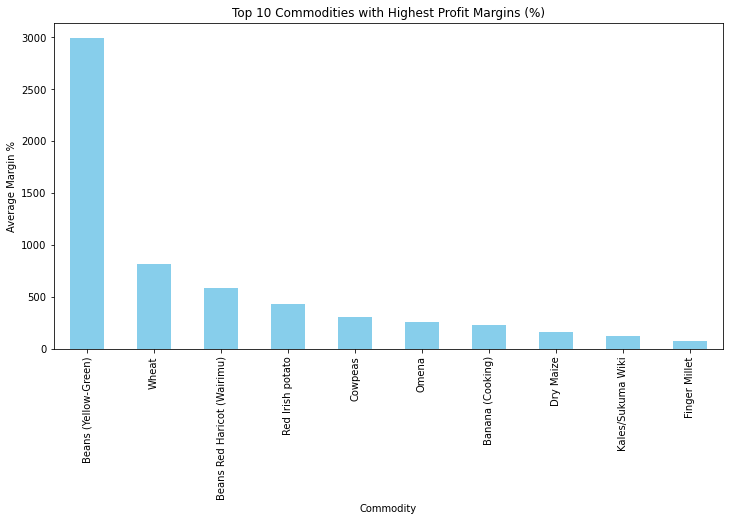

In [694]:
plt.figure(figsize=(12, 6))
data.groupby('Commodity')['Margin_Percentage'].mean().sort_values(ascending=False).head(10).plot(kind='bar', color='skyblue')
plt.title('Top 10 Commodities with Highest Profit Margins (%)')
plt.ylabel('Average Margin %')
plt.show()

**Yellow-Green beans makes the highest profit margin**

#### Which are Top 10 Counties by Total Supply Volume?

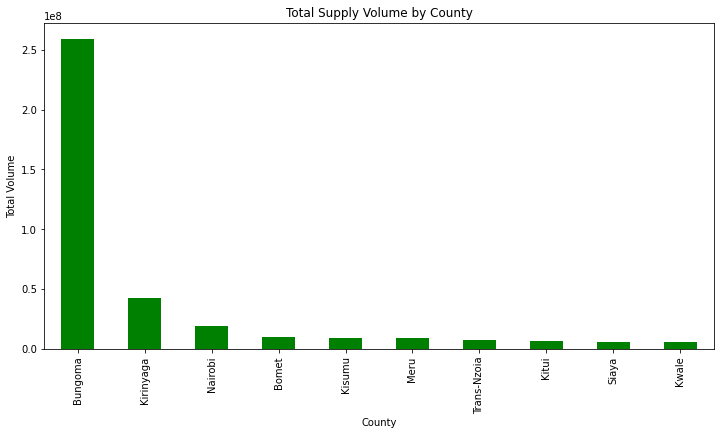

In [695]:
plt.figure(figsize=(12, 6))
data.groupby('County')['Supply Volume'].sum().sort_values(ascending=False).head(10).plot(kind='bar', color='green')
plt.title('Total Supply Volume by County')
plt.ylabel('Total Volume')
plt.show()

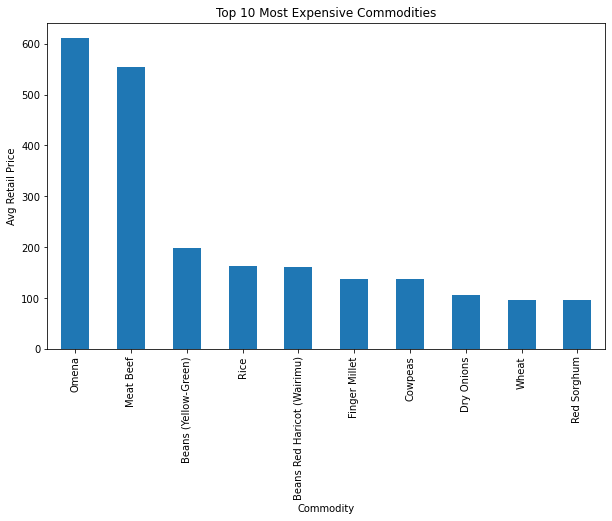

In [696]:
plt.figure(figsize=(10,6))
data.groupby('Commodity')['Retail'].mean().sort_values(ascending=False).head(10).plot(kind='bar')
plt.ylabel("Avg Retail Price")
plt.title("Top 10 Most Expensive Commodities")
plt.show()

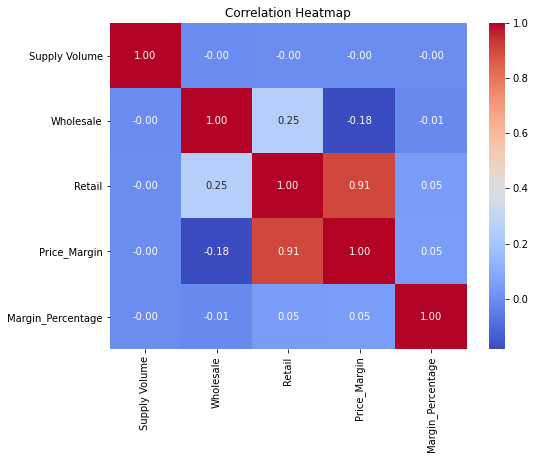

In [697]:
plt.figure(figsize=(8, 6))
correlation = data[['Supply Volume', 'Wholesale', 'Retail', 'Price_Margin', 'Margin_Percentage']].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

**Supply volume have no correlation with the prices both wholesale and retail where as The price margin has a strong positive correlation of 91% with Retail prices.**

In [698]:
# Sorting data by Date and Commodity
data = data.sort_values(['Commodity', 'Date'])

# Using linear interpolation to fill gaps in price trends
data['Retail'] = data.groupby('Commodity')['Retail'].transform(lambda x: x.interpolate(method='linear'))
data['Wholesale'] = data.groupby('Commodity')['Wholesale'].transform(lambda x: x.interpolate(method='linear'))

In [699]:
# Calculate Coefficient of Variation - a measure of volatility
volatility = data.groupby('Commodity')['Retail'].std() / data.groupby('Commodity')['Retail'].mean()
print("Top 5 Most Volatile Commodities (Hardest to predict):")
print(volatility.sort_values(ascending=False).head())

Top 5 Most Volatile Commodities (Hardest to predict):
Commodity
Banana (Cooking)               3.915273
Dry Maize                      3.300950
Beans Red Haricot (Wairimu)    3.284186
Beans (Yellow-Green)           3.184903
Finger Millet                  2.875688
Name: Retail, dtype: float64


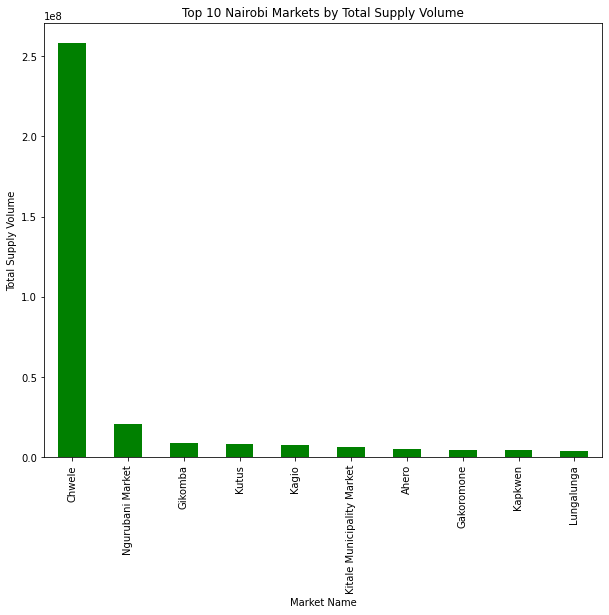

In [ ]:
plt.figure(figsize=(10,8))
data.groupby('Market')['Supply Volume'].sum().sort_values(ascending=False).head(10).plot(kind='bar', color='green')
plt.xlabel("Market Name")
plt.ylabel("Total Supply Volume")
plt.title('Top 10 Markets by Total Supply Volume')
plt.show()

In [703]:
# Create lists of markets for major cities
Nairobi_data = data[data['County'].str.contains('Nairobi', case=False, na=False)]


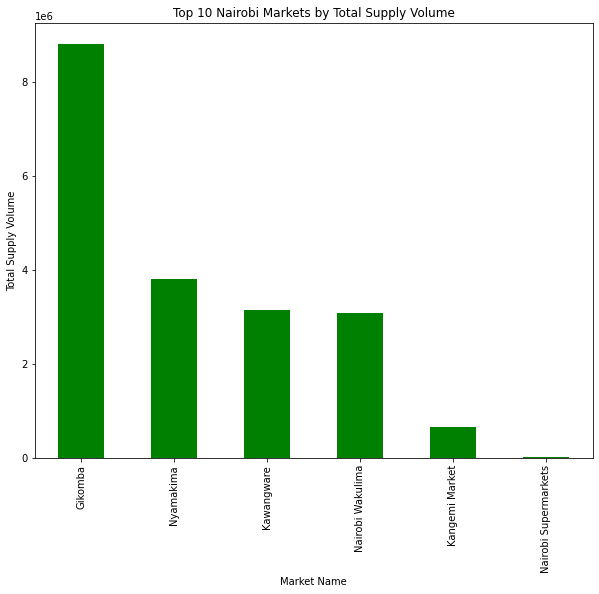

In [704]:
plt.figure(figsize=(10,8))
Nairobi_data.groupby('Market')['Supply Volume'].sum().sort_values(ascending=False).head(10).plot(kind='bar', color='green')
plt.xlabel("Market Name")
plt.ylabel("Total Supply Volume")
plt.title('Top 10 Nairobi Markets by Total Supply Volume')
plt.show()

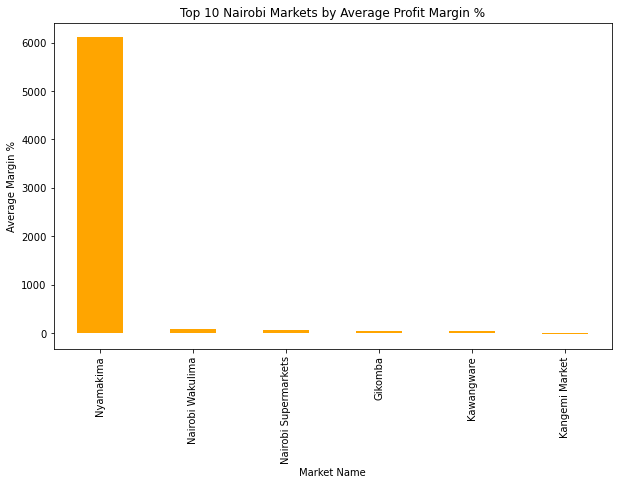

In [705]:
plt.figure(figsize=(10,6))
Nairobi_data.groupby('Market')['Margin_Percentage'].mean().sort_values(ascending=False).head(10).plot(kind='bar', color='orange')
plt.xlabel("Market Name")
plt.ylabel("Average Margin %")
plt.title('Top 10 Nairobi Markets by Average Profit Margin %')
plt.show()